In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, datetime, timedelta

import os

## Object of Portfolios and benchmarking ETF

In [2]:
class PFRebalance():

    def __init__(self, benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate, freq):
        self.benchmark = benchmark     # Benchmark equity index (e.g. S&P 500 ETF such as SPY or VOO)
        self.symbollist = symbollist   # List of all equity symbols to be considered
        self.etf_path = self.join_path(etf_path)   # ETF data path
        self.symbol_path = self.join_path(symbol_path)  
        self.startdate = startdate     # Start of buy-and-hold period
        self.enddate = enddate         # End of buy-and-hold period  
        self.rf = rf  # risk-free rate
        self.freq = freq
        self.period_dict = self.resample_dict() 
        self.pct_benchmark, self.pct_symbols = self.pctchg_period()
        self.freq_dict = {'B': 252, 'W': 52, 'M': 12, 'Q': 3, 'A': 1}
        
    def join_path(self, *args):
        """Convenient function to trace local data folders."""
        yahoo_path = os.path.join('D:\\', 'Trading', 'Data', 'eod_yahoofinance')
        return os.path.join(yahoo_path, *args)
    
    def get_data_dict(self):
        """Create dictionary matching each symbol with historical prices dataframe."""
        price_dict = dict()
        # Set the data columns of each Yahoo Finance Dataframe
        columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Collect the index ETF data into the data dict
        df_benchmark = pd.read_csv(self.join_path(self.etf_path, self.benchmark + '.csv'), 
                               header=0, index_col='date', parse_dates=True)
        df_benchmark = df_benchmark.loc[self.startdate:self.enddate]
        df_benchmark.columns = columns
        price_dict[self.benchmark] = df_benchmark
        
        # Collect each symbol data into the data dict
        for symbol in self.symbollist:
            df = pd.read_csv(self.join_path(self.symbol_path, symbol + '.csv'), 
                             header=0, index_col='date', parse_dates=True)
            df.fillna(method='ffill', inplace=True)           
            df = df.loc[self.startdate:self.enddate]
            df.columns = columns
            price_dict[symbol] = df
        
        return price_dict
    
    def resample_dict(self):
        """Resample the data dictionary with given frequency."""
        period_dict = dict()
        data_dict = self.get_data_dict()
        for key, item in data_dict.items():
            period_dict[key] = item.resample(rule=self.freq).agg(
                {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume':'sum'})
        return period_dict
    
    def pctchg_period(self):
        """Get the percentage change from resampled data."""
        pct_benchmark = pd.DataFrame(self.period_dict[self.benchmark].loc[:, ['Close']].pct_change())
        pct_symbols = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            pct_symbols[symbol] = self.period_dict[symbol].loc[:, 'Close'].pct_change()
        pct_benchmark.fillna(0, inplace=True)
        pct_symbols.fillna(0, inplace=True)
        
        return pct_benchmark, pct_symbols
    
    def pf_weight(self, weight):
        """Rebalance the portfolio by given frequency and compute each period pct change and portfolio value."""
        assert weight.min() >= 0, 'Input weight vector has negative weight!'
        assert len(weight) == len(self.symbollist), 'Length of weight vector does NOT match!'
        
        # percentage change dataframe
        pct_pf = self.pct_symbols.copy()
        pct_pf['Portfolio_rebal'] = pct_pf.mul(weight, axis=1).sum(axis=1)
        pct_pf['Benchmark'] = self.pct_benchmark

        # rebalance-mode portfolio dataframe 
        normed_pf = (pct_pf + 1).cumprod()
        
        # stationary-mode portfolio (time series attached after )
        normed_pf['Portfolio_init'] = normed_pf.loc[:, self.symbollist].mul(weight, axis=1).sum(axis=1)
        pct_pf['Portfolio_init'] = normed_pf['Portfolio_init'].pct_change()
        
        return pct_pf, normed_pf

    def pf_cov(self, weight):
        """Compute the asset corrleation & covariance and also with the portfolio and benchmark."""
        pct_pf, normed_pf = self.pf_weight(weight)
        cov_symbols = pct_pf.cov()
        corr_symbols = pct_pf.corr()
        return cov_symbols, corr_symbols
    
    def pf_kpi(self, weight):
        """Get the performance KPI from the time series of percentage or logarithmic daily return."""
        pct_pf, normed_pf = self.pf_weight(weight)
        cov_symbols, corr_symbols = self.pf_cov(weight)
        log_pf = np.log(normed_pf.pct_change().add(1))
        df_kpi = pd.DataFrame(columns=log_pf.columns)
        row_label = pd.Series(['mean_return', 'sigma', 'sharpe', 'mdd', 'beta'])
        for asset in df_kpi.columns:
            # Mean annualized return minus risk-free rate
            mean_return = log_pf[asset].mean() * self.freq_dict[self.freq] - self.rf  
            # Annualized volatility
            sd_return = log_pf[asset].std() * np.sqrt(self.freq_dict[self.freq])      
            
            df_kpi[asset] = [mean_return, sd_return, 
                             mean_return / sd_return,   # Sharpe Ratio
                             (normed_pf[asset] / normed_pf[asset].cummax()).min() - 1, # MDD
                             cov_symbols.loc[asset, 'Benchmark'] / cov_symbols.loc['Benchmark', 'Benchmark'] #beta
                            ]
        df_kpi.set_index(row_label, inplace=True)
                
        return df_kpi
    
    
    
    

## ETF Portfolio

### Monthly Rebalance

In [3]:
# US Sector ETF list 

sectorlist = ['QQQ', # Technology Index ETF
              'XLP', # Consumer Staples Sector ETF
              'XLV', # Health Care ETF
              'XLY', # Consumer Discretionary ETF
              'AGG', # Aggregate investment-grade bond ETF
              'TLT', # 20-Year Treasury Bond ETF
             ]
              
benchmark = 'SPY'         # S&P 500 ETF
etf_path = 'ETF_adjusted' # Use dividend-adjusted data, assuming dividend reinvestment
rf = 0.02
startdate = '2006-12-29'
enddate = '2019-06-30'

ETFpf = PFRebalance(benchmark, sectorlist, etf_path, etf_path, rf, startdate, enddate, 'M') # Object of ETF portfolios

eqweight = np.repeat(1/len(sectorlist), len(sectorlist))
pct_etf, normed_etf = ETFpf.pf_weight(eqweight)

normed_etf.tail(6)



,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio_rebal,Benchmark,Portfolio_init
date,,,,,,,,,
2019-01-31,4.342885,2.816591,3.337434,3.387956,1.568855,2.041912,2.953159,2.438039,2.915939
2019-02-28,4.472789,2.866708,3.373506,3.432494,1.567070,2.013807,2.981095,2.517070,2.954396
2019-03-31,4.648327,2.976302,3.389764,3.557961,1.600332,2.126009,3.078373,2.562630,3.049783
2019-04-30,4.903952,3.061172,3.297769,3.752344,1.597126,2.083679,3.124081,2.667320,3.116007
2019-05-31,4.500593,2.949780,3.224617,3.467020,1.627644,2.226187,3.056725,2.497222,2.999307
2019-06-30,4.842190,3.103745,3.437248,3.737999,1.645526,2.247338,3.205833,2.670994,3.169008


### Weekly Rebalance

In [4]:
ETFpf_w = PFRebalance(benchmark, sectorlist, etf_path, etf_path, rf, startdate, enddate, 'W')

pct_etf_w, normed_etf_w = ETFpf_w.pf_weight(eqweight)

pct_etf_w.tail(6)

,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio_rebal,Benchmark,Portfolio_init
date,,,,,,,,,
2019-05-26,-0.026661,-0.003983,0.012664,-0.021396,0.003485,0.014207,-0.003614,-0.010705,-0.007531
2019-06-02,-0.023630,-0.033206,-0.025458,-0.021952,0.009049,0.031695,-0.010584,-0.026558,-0.015822
2019-06-09,0.040759,0.054307,0.042736,0.043627,0.003541,0.001368,0.031056,0.044974,0.035647
2019-06-16,0.008838,0.007846,0.002637,0.023406,0.000362,-0.002125,0.006827,0.005597,0.008328
2019-06-23,0.032468,0.001312,0.031561,0.012170,0.004974,-0.000228,0.013710,0.021330,0.016849
2019-06-30,-0.007515,-0.011069,-0.011629,-0.002677,0.002070,0.010500,-0.003387,-0.003401,-0.004978


In [5]:
normed_etf_w.tail(6)   # portfolio_init gets same normed value at 2019-06-30 as the month version

,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio_rebal,Benchmark,Portfolio_init
date,,,,,,,,,
2019-05-26,4.609518,3.051094,3.308853,3.544836,1.613049,2.157795,3.144101,2.565352,3.047524
2019-06-02,4.500593,2.949780,3.224617,3.467020,1.627644,2.226187,3.110824,2.497222,2.999307
2019-06-09,4.684032,3.109973,3.362424,3.618276,1.633408,2.229232,3.207435,2.609532,3.106224
2019-06-16,4.725428,3.134373,3.371291,3.702967,1.633999,2.224494,3.229333,2.624138,3.132092
2019-06-23,4.878855,3.138486,3.477691,3.748034,1.642127,2.223987,3.273606,2.680110,3.184863
2019-06-30,4.842190,3.103745,3.437248,3.737999,1.645526,2.247338,3.262519,2.670994,3.169008


## Correlation

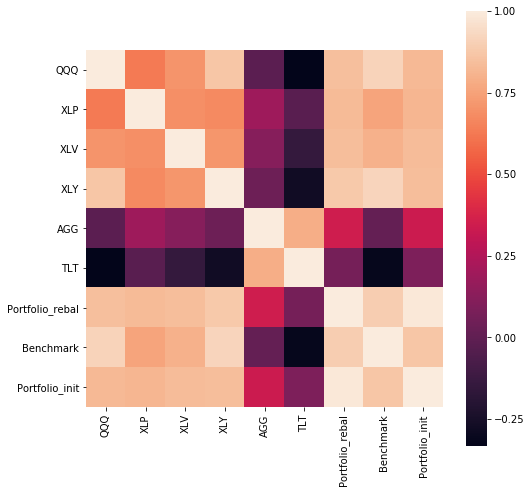

In [6]:
import seaborn as sns

cov_pf, corr_pf = ETFpf.pf_cov(eqweight)

# Using Heatmap to illustrate corrleation matrix 
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_pf, square=True, ax=ax)

In [7]:
etf_kpi = ETFpf_w.pf_kpi(eqweight)
etf_kpi

,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio_rebal,Benchmark,Portfolio_init
mean_return,0.105802,0.070331,0.078471,0.085160,0.019723,0.044581,0.074310,0.058355,0.071990
sigma,0.194652,0.129443,0.165456,0.209272,0.050826,0.135006,0.102202,0.180820,0.100416
sharpe,0.543545,0.543335,0.474269,0.406936,0.388044,0.330216,0.727088,0.322725,0.716923
mdd,-0.514472,-0.313425,-0.379124,-0.584314,-0.123100,-0.251822,-0.269962,-0.546130,-0.242071
beta,0.989078,0.568483,0.744259,1.079663,0.026201,-0.302788,0.517483,1.000000,0.487480


## Object of Portfolio Optimizer 

- Use uniform distribution to generate weights 
- Adopt "Max entropy principle" based on assumption that we have no significant prior knowledge 

In [8]:
from scipy.optimize import minimize

class PFRandomizer(PFRebalance):
    
    def __init__(self, benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate, freq, rand_size):
        super().__init__(benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate, freq)
        self.log_benchmark, self.log_symbols = self.logpct()
        self.rand_size = rand_size               # Number of simulations
        self.rand_weight = self.get_randweight() # Dataframe consisting of each random weight
    
    def logpct(self):
        log_benchmark = np.log(self.pct_benchmark.add(1))
        log_symbols = np.log(self.pct_symbols.add(1))
        return log_benchmark, log_symbols
    
    def get_randweight(self):
        """Generate random weights from uniform distribution and store them into a dataframe."""
        df_weight = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_weight[symbol] = np.random.uniform(size=self.rand_size)
        df_weight = df_weight.div(df_weight.sum(axis=1), axis=0)
        
        return df_weight

    def meanvar_sharpe(self, weight, start, end):
        """Compute Sharpe ratio with mean-variance method."""
        log_benchmark_period = self.log_benchmark.loc[start:end]
        log_symbols_period = self.log_symbols.loc[start:end]
        log_return = pd.concat([log_benchmark_period, log_symbols_period], axis=1)
        mean_log = self.freq_dict[self.freq] * np.sum(log_symbols_period.mean() * weight)
        sd_log = np.sqrt(self.freq_dict[self.freq] * np.dot(weight, np.dot(log_symbols_period.cov(), weight)))
        sharpe = mean_log / sd_log
        return np.array([mean_log, sd_log, sharpe])
    
    def sharpe_array(self, start, end):
        """Mean-variance Sharpe ratio dataframe for the random weights."""
        sharpe_randweight = self.rand_weight.copy()
        stat_list = [self.meanvar_sharpe(weight[1], start, end) for weight in self.rand_weight.iterrows()]
        sharpe_randweight['log_mean%'] = np.array([item[0] for item in stat_list])
        sharpe_randweight['log_sigma%'] = np.array([item[1] for item in stat_list])
        sharpe_randweight['log_sharpe'] = np.array([item[2] for item in stat_list])
        return sharpe_randweight
        
    def randweight_kpi(self, start, end):
        """Compute KPI's from percentage change datakp for each randomized portfolio, 
           both periodcal rebalance and no rebalance."""
        kpi_columns = ['init_mean%', 'init_sigma%', 'init_sharpe', 'init_beta', 'init_mdd',
                       'rebal_mean%', 'rebal_sigma%', 'rebal_sharpe', 'rebal_beta', 'rebal_mdd']
        df_kpi = pd.DataFrame(columns=kpi_columns)
        
        # Benchmark log change
        log_benchmark = self.log_benchmark
        
        for num in range(self.rand_size):
            weight = self.rand_weight.iloc[num, :]
            pct_weight, normed_weight = self.pf_weight(weight)

            # non-rebalance portfolio
            pct_init = pct_weight.loc[start:end, 'Portfolio_init']
            period_init = normed_weight.loc[start:end, 'Portfolio_init']
            log_init = np.log(pct_init + 1)
            
            # KPI for non-rebalance portfolio
            init_mean = log_init.mean() * self.freq_dict[self.freq] - self.rf  
            init_sd = log_init.std() * np.sqrt(self.freq_dict[self.freq])
            init_sharpe = init_mean / init_sd
            
            init_cov = pd.concat([log_init, log_benchmark], axis=1).cov()
            init_beta = init_cov.iloc[0,1] / init_cov.iloc[1, 1]   # beta
            init_mdd = (period_init / period_init.cummax()).min() - 1
            
            # rebalance portfolio
            pct_rebal = pct_weight.loc[start:end, 'Portfolio_rebal']
            period_rebal = normed_weight.loc[start:end, 'Portfolio_rebal']
            log_rebal = np.log(pct_rebal + 1)            
            
            # KPI for rebalance portfolio
            rebal_mean = log_rebal.mean() * self.freq_dict[self.freq] - self.rf  
            rebal_sd = log_rebal.std() * np.sqrt(self.freq_dict[self.freq])
            rebal_sharpe = rebal_mean / rebal_sd
            
            rebal_cov = pd.concat([log_rebal, log_benchmark], axis=1).cov()
            rebal_beta = rebal_cov.iloc[0,1] / rebal_cov.iloc[1, 1]   # beta
            rebal_mdd = (period_rebal / period_rebal.cummax()).min() - 1
            
            df_kpi = df_kpi.append({'init_mean%': init_mean, 'init_sigma%': init_sd, 
                                    'init_sharpe': init_sharpe, 'init_beta': init_beta, 'init_mdd': init_mdd,
                                    'rebal_mean%': rebal_mean, 'rebal_sigma%': rebal_sd,
                                    'rebal_sharpe': rebal_sharpe, 'rebal_beta': rebal_beta, 'rebal_mdd': rebal_mdd}, 
                                    ignore_index=True)
    
        # Merge with mean-var sharpe array 
        meanvar_kpi = self.sharpe_array(start, end)
        df_kpi = pd.concat([self.rand_weight, df_kpi, meanvar_kpi.loc[:, ['log_mean%', 'log_sigma%', 'log_sharpe']]], axis=1)
    
        return df_kpi
              
    def train_test_split(self, train_start, train_end, test_start, test_end):
        """Split the dataset into training set and test set, with normed prices in each of two datasets."""
        train_kpi = self.randweight_kpi(train_start, train_end)
        test_kpi = self.randweight_kpi(test_start, test_end)
        
        return train_kpi, test_kpi
    
    def opt_frontier(self, train_start, train_end, lower_mean, upper_mean, lower_sigma, upper_sigma):
        """Perform Markowitz optimization."""
        
        # Perform train-test-split to train random portfolios
        train_kpi, test_kpi = self.train_test_split(train_start, train_end, train_end, self.enddate)
        
        def get_neg_sharpe(weight):
            """Return the negative Sharpe ratio for given weight"""
            return -self.meanvar_sharpe(weight, train_start, train_end)[2]
        
        def check_unity(weight):
            """Return 0 if sum of weights equals 1"""
            return np.sum(weight)-1

        def get_sigma(weight):
            return self.meanvar_sharpe(weight, train_start, train_end)[1]
        
        # Use scipy minimize to obtain the Markowitz portfolio
        eqweight = np.repeat(1/len(self.symbollist), len(self.symbollist))
        init_guess = eqweight                                                # Initial guess set at uniform allocation
        bounds = tuple((0,1) for num in range(len(self.symbollist)))         # Bounds of elements of weight vector
        constr = {'type':'eq','fun':check_unity}                             # Constraint Vector: dictionary object
        
        opt_portfo_results = minimize(get_neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=constr)
        opt_weight = opt_portfo_results.x    # Markowitz Allocation
        opt_sharpe = self.meanvar_sharpe(opt_weight, train_start, train_end)

        # Efficient Frontier Optimization
        return_vect = np.linspace(lower_mean, upper_mean,100)    # Input Vector: annualized return from 0.025 to 0.200
        frontier_vol = []                                        # Record the minimal volatility for each
        init_guess = eqweight                                    # initial guess as equal weight
        
        for value in return_vect:
            # Set up two constraints for opt: weight unity & fixed return
            constr = ({'type':'eq','fun':check_unity},
                      {'type':'eq','fun':lambda w: self.meanvar_sharpe(w, train_start, train_end)[0] - value})
            min_vol_result = minimize(get_sigma, init_guess,method='SLSQP',bounds=bounds,constraints=constr)
            # Store the result of minimising volatility  
            frontier_vol.append(min_vol_result['fun'])       
       
        # Constructing Pie Chart
        fig, ax = plt.subplots(figsize=(8,8))
        ax.pie(opt_weight, labels=self.symbollist, autopct='%1.2f%%', shadow=False, startangle=90)
        ax.axis('equal')

        # Scatter plot of all (sigma, return)-tuple of the 2500 portfolios 
        plt.figure(figsize=(12,12))
        fig = plt.scatter(train_kpi['sigma%'], train_kpi['mean%'] + rf, c=train_kpi['sharpe'], cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('portfolio volatitlity')
        plt.ylabel('portfolio return')

        # Add frontier line 
        plt.plot(frontier_vol,return_vect + rf,'g--',linewidth=2)
        
        # Add red dot for the Markowitz portfolio
        plt.scatter(opt_sharpe[1], opt_sharpe[0], c='green',s=50,edgecolors='black')

        # Add straight line of optimal portfolios
        xline = np.linspace(lower_sigma, upper_sigma, 500)
        yline = opt_sharpe * xline + rf
        plt.plot(xline, yline, 'b-', linewidth=2)

        # Set annualized return range 
        plt.ylim(bottom=0)
        plt.ylim(top=upper_sigma)

        # Set sigma range
        plt.xlim(left=0)
        plt.xlim(right=upper_sigma)
        plt.show()
        
        return opt_weight, opt_sharpe, list(zip(return_vect, frontier_vol))



In [9]:
class PFOptimizer():
    
    def __init__(self, symbollist, rf, train_kpi, train_start, train_end, test_kpi=None, test_start=None, test_end=None):
        self.symbollist = symbollist
        self.rf = rf
        self.train_kpi = train_kpi
        self.train_start = train_start
        self.train_end = train_end
        self.test_kpi = test_kpi
        self.test_start = test_start
        self.test_end = test_end
        self.rand_size = self.train_kpi.shape[0]
    
    def sort_metric(self, metric='sharpe', method='rebal'):
        """Sort KPI dataframe according to a metric."""
        if (method != 'init') and (method != 'rebal') and (method != 'log'):
            raise ValueError('Inappropriate portfolio method!')
        
        ascend_dict = {'sharpe': False, 'mean%': False, 'sigma%': True, 'beta': True, 'mdd': False}
        df_sort_metric = self.train_kpi.sort_values([method + '_' + metric], ascending=ascend_dict[metric])
        df_sort_metric.reset_index(inplace=True)
        
        return df_sort_metric
    
    def top_allocation(self, percentile, metric='sharpe', method='rebal'):
        """Store top percentile metric portfolio and display average allocation."""
        df_sort_metric = self.sort_metric(metric, method)
        top_metric = df_sort_metric.head(int(percentile*self.rand_size))
        mean_data = pd.DataFrame(top_metric.mean()).transpose()
        mean_data.drop(['index'], axis=1, inplace=True)
        
        # Plotting allocation 
        mean_allocation = mean_data.loc[0, self.symbollist]    
        fig, ax = plt.subplots(figsize=(8,8))
        ax.pie(mean_allocation, labels=self.symbollist, autopct='%1.2f%%', shadow=False, startangle=90)
        ax.axis('equal')
        plt.show()
        
        return top_metric, mean_data
    
    def train_visualize(self, percentile, metric='sharpe', method='rebal', color='cyan'):
        """Visualize training set data. """
        df_sort_metric = self.sort_metric(metric, method)
        top_metric, mean_data = self.top_allocation(percentile, metric, method)
        
        # Scatter plot of all (sigma, return)-tuple of the 2500 portfolios 
        plt.figure(figsize=(12,12))
        fig = plt.scatter(df_sort_metric[method + '_sigma%'], 
                          df_sort_metric[method + '_mean%'] + rf, 
                          c=df_sort_metric[method + '_sharpe'], cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('portfolio volatitlity')
        plt.ylabel('portfolio return')

        # Add cyan dots for top metric
        top = plt.scatter(top_metric[method + '_sigma%'], top_metric[method + '_mean%'] + rf, c=color, s=50, edgecolors='black')

        # Add straight line of optimal portfolios
        xline = np.linspace(0, 1, 500)
        yline = top_metric[method + '_sharpe'].min() * xline + rf
        plt.plot(xline, yline, 'b-', linewidth=2)

        # Set annualized return range from 0 to 24%
        plt.ylim(bottom=0)
        plt.ylim(top=0.2)

        # Set sigma range from 0 to 24%
        plt.xlim(left=0)
        plt.xlim(right=0.2)
        plt.show()
        
    def test_compare(self, percentile, metric='sharpe', method='rebal'):
        """Apply top allocations in training set to test set."""
        top_metric, mean_data = self.top_allocation(percentile, metric, method)
        top_index = top_metric.loc[:int(percentile*self.rand_size), 'index']
        test_top = self.test_kpi.loc[top_index]
        mean_test_top = pd.DataFrame(test_top.mean()).transpose()
        
        # Scatter plot of all (sigma, return)-tuple of the 2500 portfolios 
        plt.figure(figsize=(12,12))
        fig = plt.scatter(self.test_kpi[method + '_sigma%'], 
                          self.test_kpi[method + '_mean%'] + rf, 
                          c=self.test_kpi[method + '_sharpe'], cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('portfolio volatitlity')
        plt.ylabel('portfolio return')

        # Add cyan dots for top metric
        top = plt.scatter(test_top[method + '_sigma%'], test_top[method + '_mean%'] + rf, c='cyan', s=50, edgecolors='black')

        # Add straight line of optimal portfolios
        xline = np.linspace(0, 1, 500)
        yline = test_top[method + '_sharpe'].max() * xline + rf
        plt.plot(xline, yline, 'b-', linewidth=2)

        # Set annualized return range from 0 to 24%
        plt.ylim(bottom=0)
        plt.ylim(top=0.2)

        # Set sigma range from 0 to 24%
        plt.xlim(left=0)
        plt.xlim(right=0.2)
        plt.show()        
        
        return test_top, mean_test_top
    

        
    

## Simulate 1000 portfolios

In [10]:
# Initialize ETF portfolio Optimizer
rand_size = 1000
ETF_rand = PFRandomizer(benchmark, sectorlist, etf_path, etf_path, rf, startdate, enddate, 'M', rand_size)

# Random Weights
etf_weight = ETF_rand.rand_weight  



In [11]:
# Start time count for simulations
from time import time
start_time = time()

# KPI corresponding to each portfolio
etf_kpi = ETF_rand.randweight_kpi(startdate, enddate)

# Check time elapsed
print('\nTime elapsed: ', time() - start_time)


Time elapsed:  26.537987232208252


## Average weights of top 25 Sharpe-ratio portfolios (pie chart)

In [12]:
rf = 0.02
startdate = '2006-12-29'
enddate = '2019-06-30'

ETF_opt = PFOptimizer(sectorlist, rf, etf_kpi, startdate, enddate)
rebal_sort_sharpe = ETF_opt.sort_metric('sharpe', method='rebal')
rebal_sort_sharpe.head()

,index,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,215,0.259261,0.118245,0.024751,0.015008,0.305775,0.276961,0.064877,0.074755,0.867861,0.335691,-0.126252,0.062790,0.068398,0.918016,0.310965,-0.141415,0.077069,0.068725,1.121407
1,299,0.273023,0.032877,0.107614,0.031954,0.261587,0.292945,0.067948,0.079096,0.859052,0.369748,-0.143816,0.066520,0.072754,0.914308,0.351169,-0.163764,0.080296,0.073175,1.097320
2,843,0.225685,0.074095,0.082933,0.049191,0.298441,0.269654,0.064868,0.075239,0.862162,0.348328,-0.131697,0.063265,0.069462,0.910792,0.331467,-0.153335,0.077417,0.069831,1.108633
3,556,0.230345,0.033206,0.133906,0.017739,0.239589,0.345215,0.065592,0.077375,0.847709,0.311574,-0.127844,0.064706,0.071136,0.909614,0.294727,-0.138802,0.078559,0.071433,1.099760
4,147,0.237154,0.126904,0.133972,0.030878,0.104240,0.366852,0.070875,0.084183,0.841924,0.374224,-0.155982,0.071858,0.079147,0.907906,0.366032,-0.177725,0.085265,0.079535,1.072040


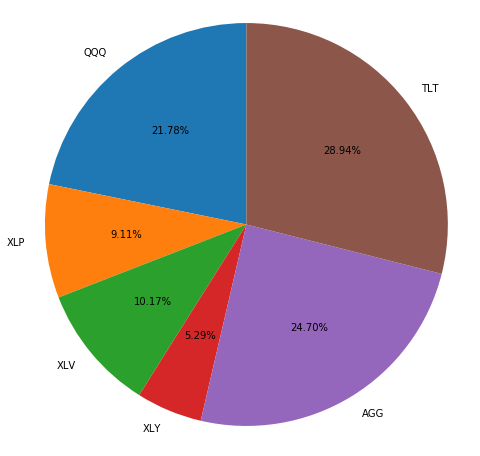

In [13]:
top_rebal_sharpe, mean_rebal_sharpe = ETF_opt.top_allocation(0.025, method='rebal')

In [14]:
mean_rebal_sharpe

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.217849,0.091141,0.10172,0.052907,0.246987,0.289397,0.066255,0.078176,0.847888,0.358544,-0.142585,0.065401,0.072868,0.897661,0.345733,-0.162677,0.079435,0.073238,1.086002


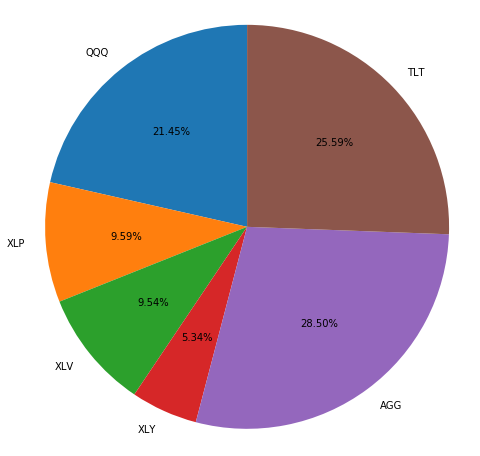

In [15]:
top_init_sharpe, mean_init_sharpe = ETF_opt.top_allocation(0.025, method='init')

In [16]:
mean_init_sharpe

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.214504,0.095905,0.095363,0.05335,0.28499,0.255888,0.065311,0.076774,0.850839,0.365043,-0.143634,0.063941,0.07146,0.894813,0.350126,-0.162855,0.078215,0.071848,1.089817


## Average weights of top 25 Return portfolios (pie chart)

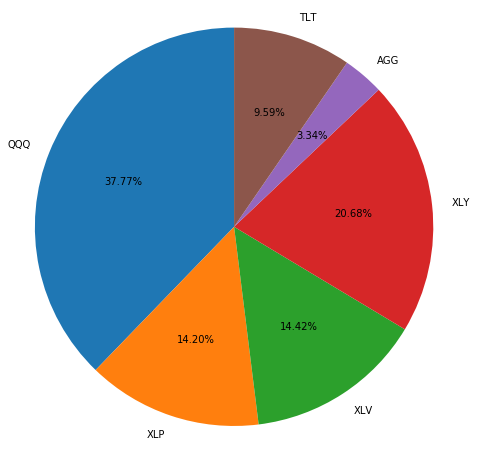

In [17]:
top_rebal_return, mean_rebal_return = ETF_opt.top_allocation(0.025, metric='mean%', method='rebal')

In [18]:
mean_rebal_return

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.377681,0.142013,0.144248,0.206751,0.033383,0.095923,0.086958,0.126886,0.689298,0.804382,-0.366655,0.087853,0.126568,0.699081,0.805752,-0.378834,0.103438,0.127058,0.819062


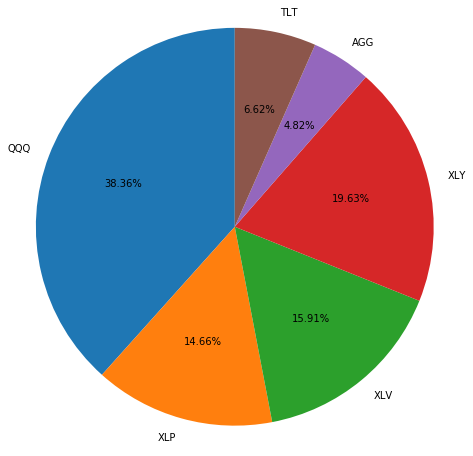

In [19]:
top_init_return, mean_init_return = ETF_opt.top_allocation(0.025, metric='mean%', method='init')

In [20]:
mean_init_return

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.383608,0.146551,0.159124,0.196283,0.048248,0.066186,0.087224,0.129235,0.677659,0.825068,-0.375317,0.087644,0.128682,0.684481,0.823233,-0.385242,0.103627,0.129129,0.805993


## Scatter Plot & Optimal Rebalance Portfolios

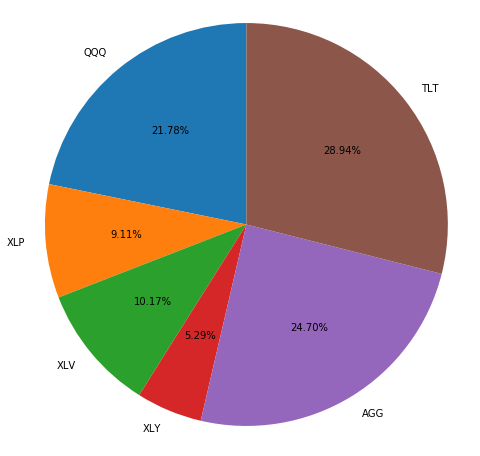

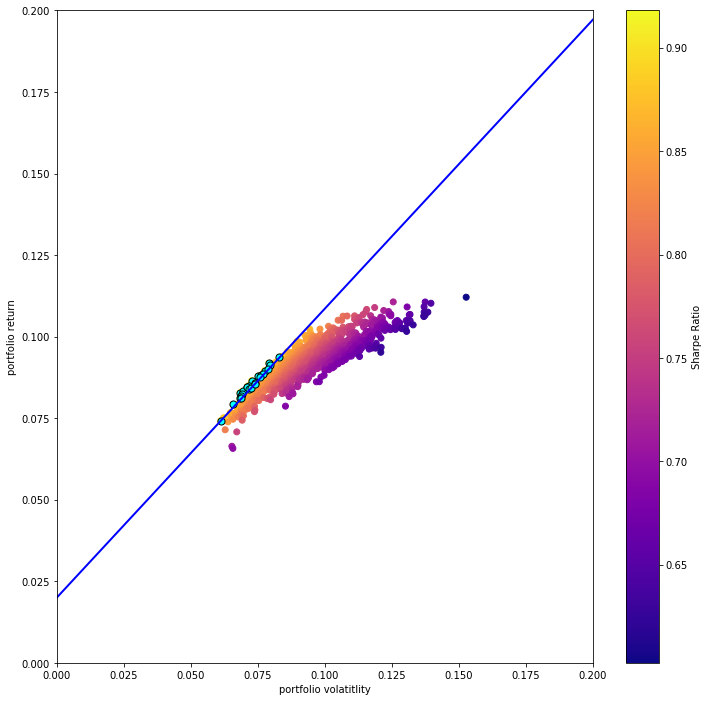

In [21]:
ETF_opt.train_visualize(0.025, metric='sharpe', method='rebal', color='cyan')

## Train-test-split on asset weights (2012-12-31)

In [22]:
start_time = time()

train_end = '2012-12-31'
train_kpi_2008, test_kpi_2008 = ETF_rand.train_test_split(startdate, train_end, train_end, enddate)

print('Time elapsed: ', time() - start_time)


Time elapsed:  51.43340444564819


### Monthly rebalance model

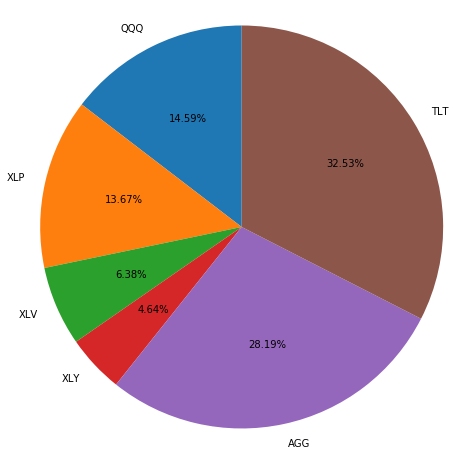

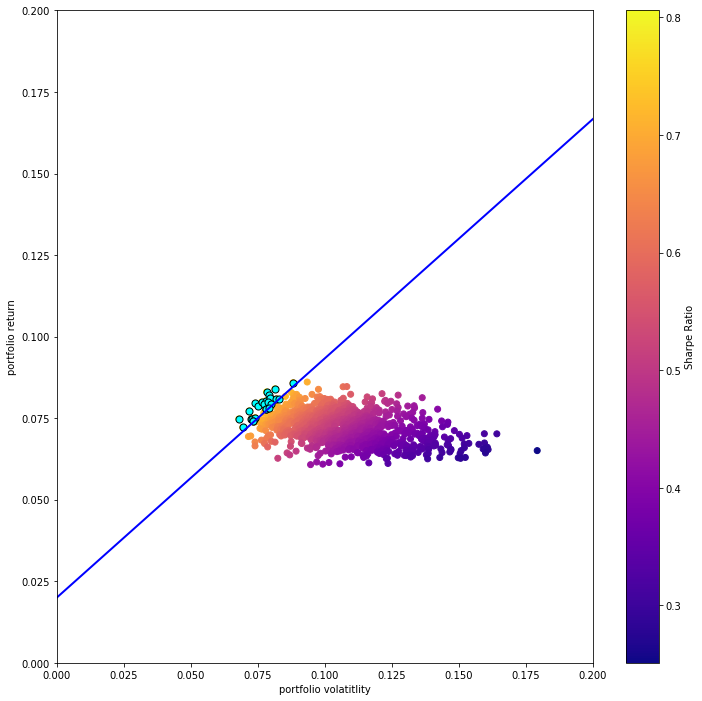

In [23]:
ETF_split_08 = PFOptimizer(sectorlist, rf, train_kpi_2008, startdate, train_end, test_kpi_2008, train_end, enddate)
ETF_split_08.train_visualize(0.025, metric='sharpe', method='rebal', color='cyan')

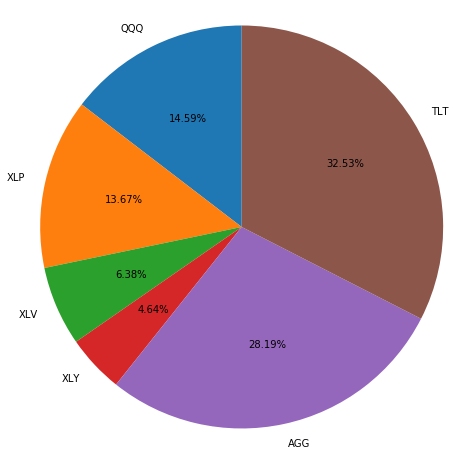

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.145945,0.136704,0.063843,0.046393,0.28186,0.325255,0.053268,0.078568,0.678675,0.286933,-0.116961,0.058634,0.076893,0.762937,0.346984,-0.126587,0.071572,0.07712,0.929634


In [24]:
top_init_2008, mean_init_2008 = ETF_split_08.top_allocation(0.025, metric='sharpe', method='rebal')
mean_init_2008

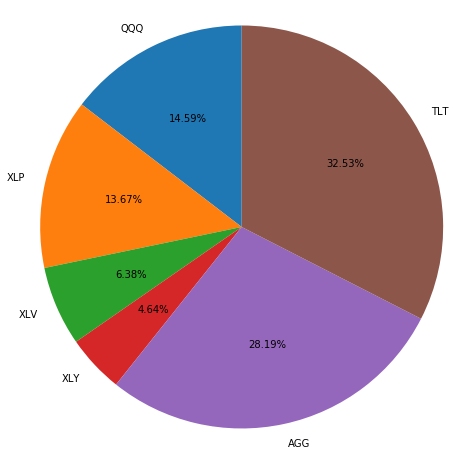

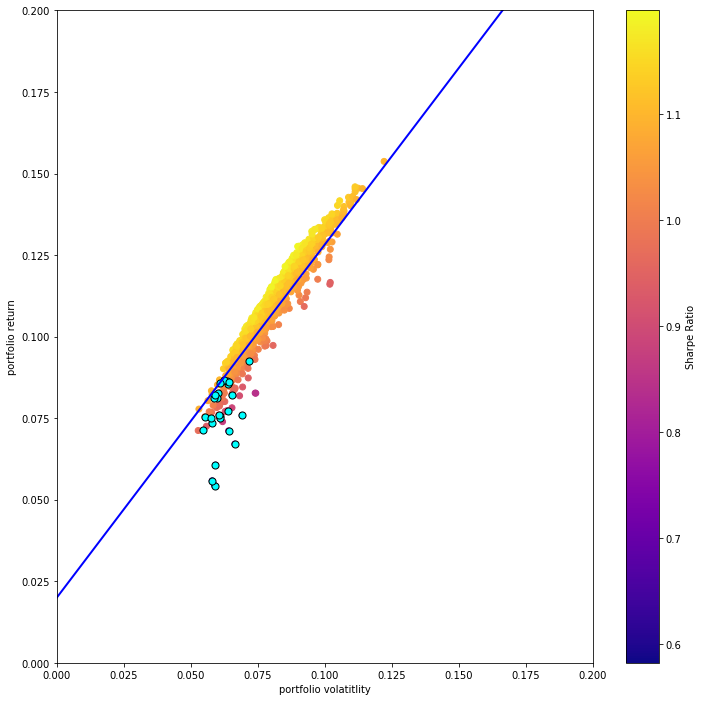

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.145945,0.136704,0.063843,0.046393,0.28186,0.325255,0.062733,0.069968,0.892241,0.235116,-0.07495,0.056646,0.061498,0.920915,0.160128,-0.068987,0.073055,0.061584,1.187255


In [25]:
test_top_2008, mean_test_top_2008 = ETF_split_08.test_compare(0.025, metric='sharpe', method='rebal')
mean_test_top_2008

### Using mean-var model

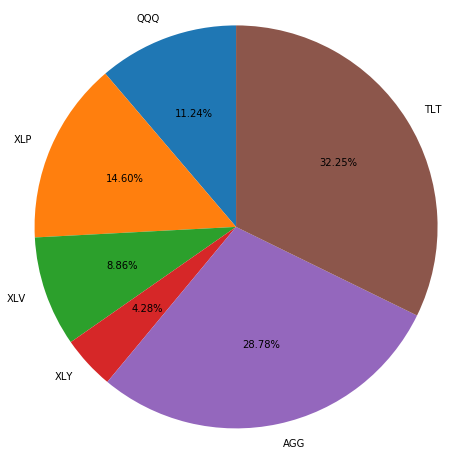

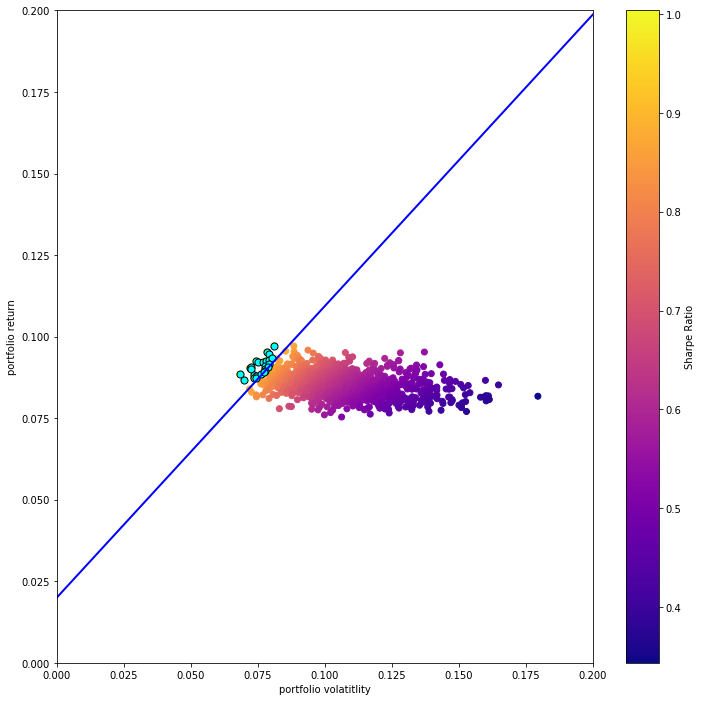

In [26]:
ETF_split_08.train_visualize(0.025, metric='sharpe', method='log', color='cyan')

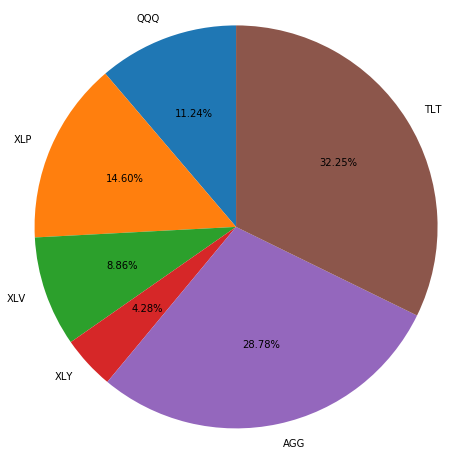

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.112396,0.145958,0.088552,0.042808,0.287818,0.322467,0.052567,0.07781,0.676097,0.263762,-0.113109,0.057489,0.075769,0.758875,0.322542,-0.1203,0.070842,0.075959,0.933402


In [27]:
top_init_2008, mean_init_2008 = ETF_split_08.top_allocation(0.025, metric='sharpe', method='log')
mean_init_2008

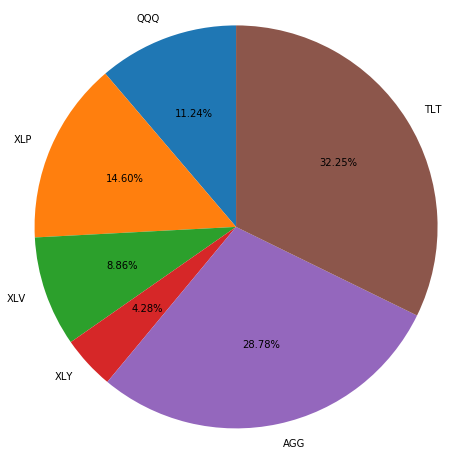

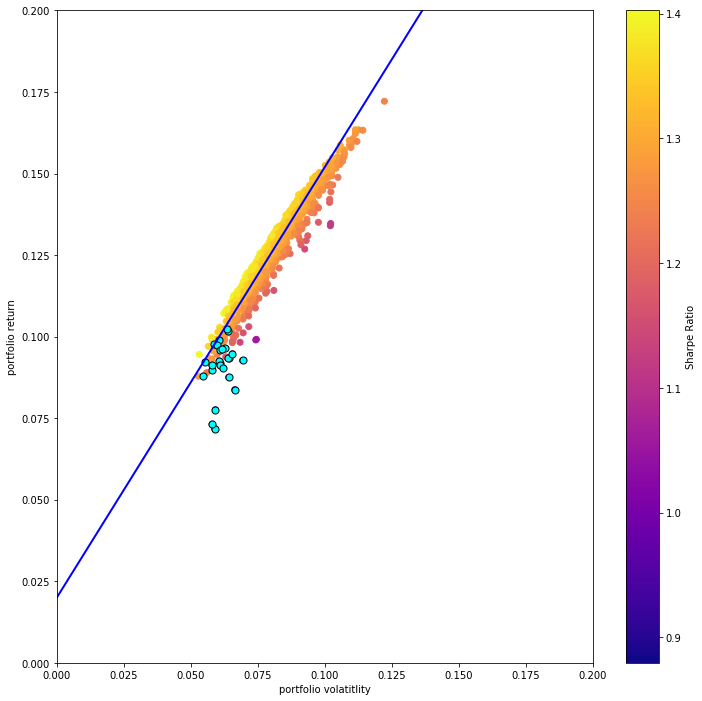

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.112396,0.145958,0.088552,0.042808,0.287818,0.322467,0.06015,0.068924,0.869823,0.223765,-0.074993,0.054797,0.061177,0.896477,0.153342,-0.072076,0.071294,0.061264,1.165293


In [28]:
test_top_2008, mean_test_top_2008 = ETF_split_08.test_compare(0.025, metric='sharpe', method='log')
mean_test_top_2008

## Train-test-split post 2008

In [29]:
start_time = time()

train_start_2010 = '2009-12-31'
train_end_2014 = '2014-12-31'
train_kpi_2010, test_kpi_2010 = ETF_rand.train_test_split(train_start_2010, train_end_2014, train_end_2014, enddate)

print('Time elapsed: ', time() - start_time)

Time elapsed:  52.582114934921265


### Using monthly rebalance model

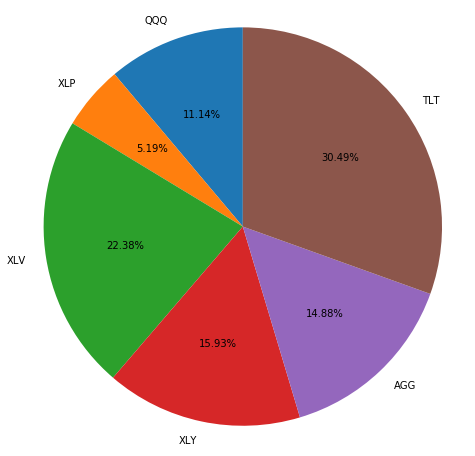

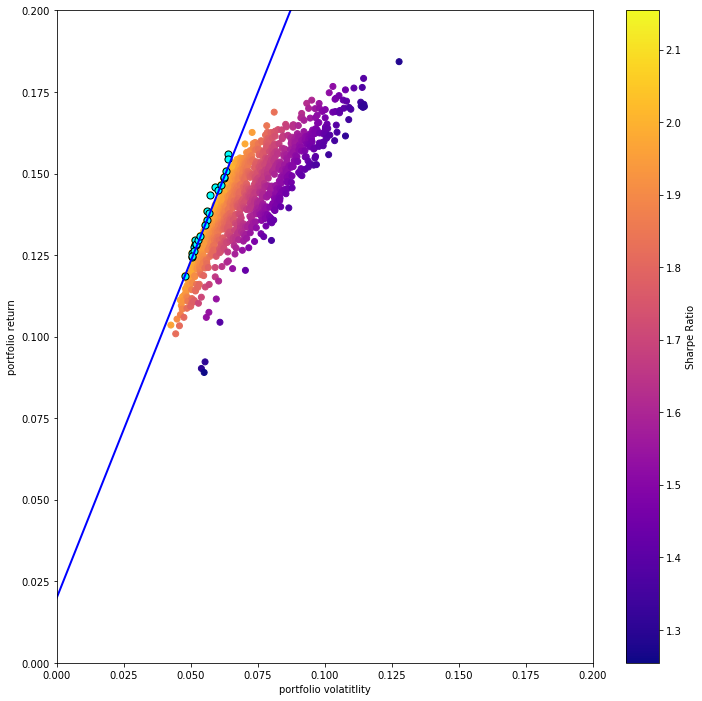

In [31]:
ETF_split_10 = PFOptimizer(sectorlist, rf, train_kpi_2010, startdate, train_end_2014, test_kpi_2010, train_end_2014, enddate)
ETF_split_10.train_visualize(0.025, metric='sharpe', method='rebal', color='cyan')

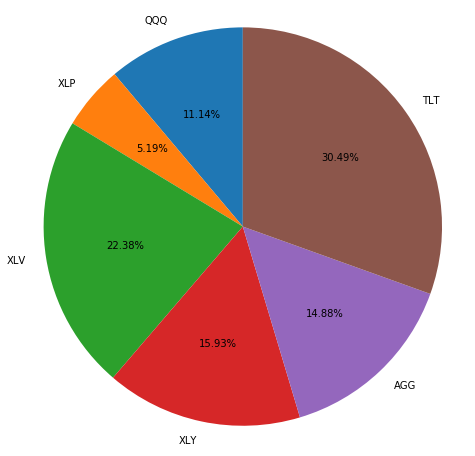

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.111391,0.051872,0.223805,0.159252,0.148804,0.304876,0.110572,0.054581,2.024746,0.141794,-0.029521,0.116328,0.0557,2.088307,0.191217,-0.031943,0.13037,0.055655,2.345336


In [32]:
top_init_2014, mean_init_2014 = ETF_split_10.top_allocation(0.025, metric='sharpe', method='rebal')
mean_init_2014

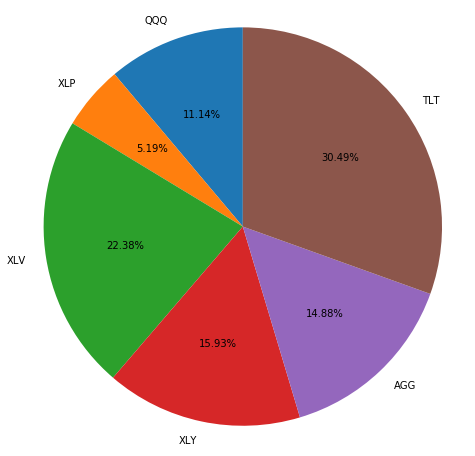

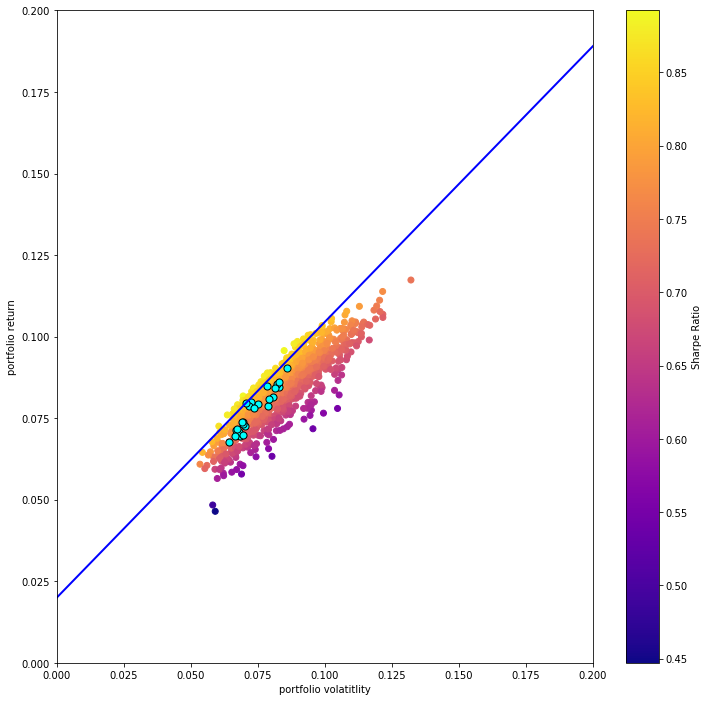

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.111391,0.051872,0.223805,0.159252,0.148804,0.304876,0.060913,0.086247,0.705585,0.398831,-0.077608,0.05746,0.073853,0.776959,0.304362,-0.068346,0.072678,0.074099,0.981503


In [33]:
test_top_2014, mean_test_top_2014 = ETF_split_10.test_compare(0.025, metric='sharpe', method='rebal')
mean_test_top_2014

### Using mean-var model

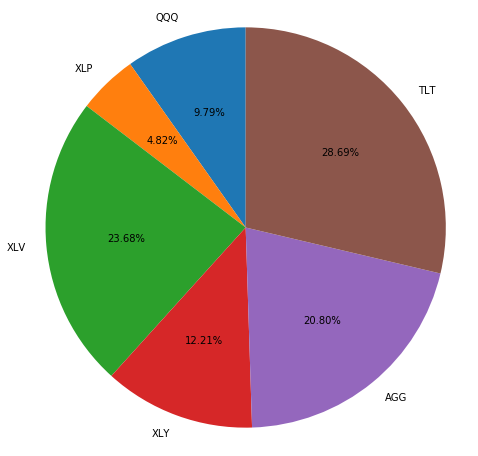

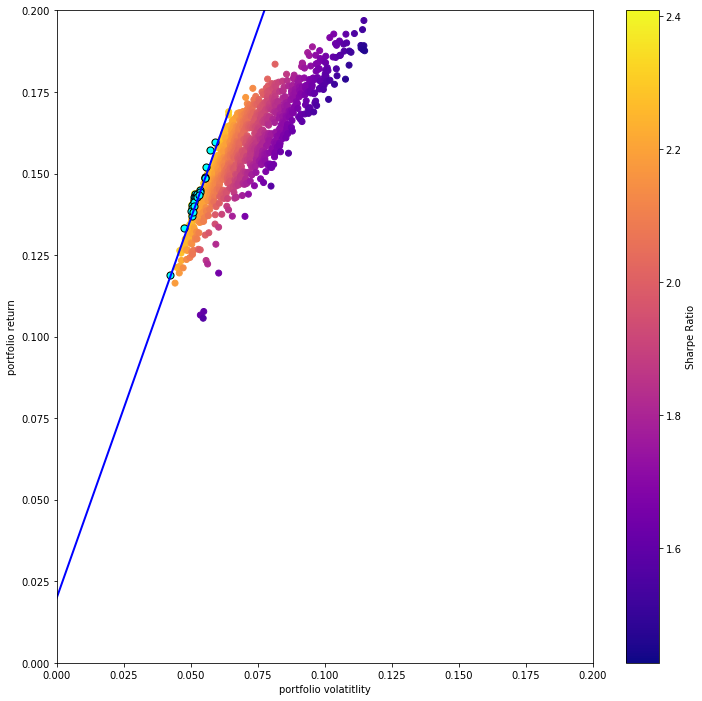

In [35]:
ETF_split_10 = PFOptimizer(sectorlist, rf, train_kpi_2010, startdate, train_end_2014, test_kpi_2010, train_end_2014, enddate)
ETF_split_10.train_visualize(0.025, metric='sharpe', method='log', color='cyan')


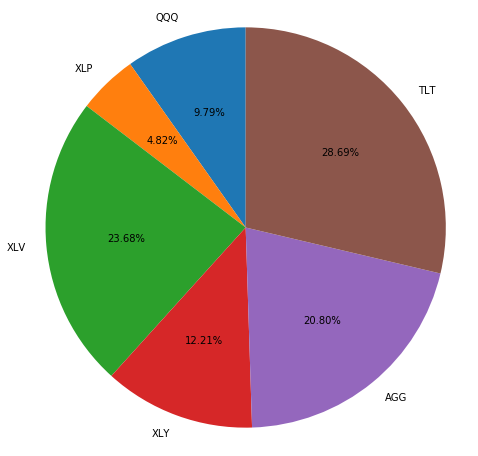

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.097942,0.048228,0.236766,0.122149,0.208011,0.286904,0.104059,0.05216,1.99406,0.11783,-0.030561,0.108554,0.052324,2.073143,0.162536,-0.029677,0.12302,0.052219,2.355906


In [36]:
top_init_2014, mean_init_2014 = ETF_split_10.top_allocation(0.025, metric='sharpe', method='log')
mean_init_2014

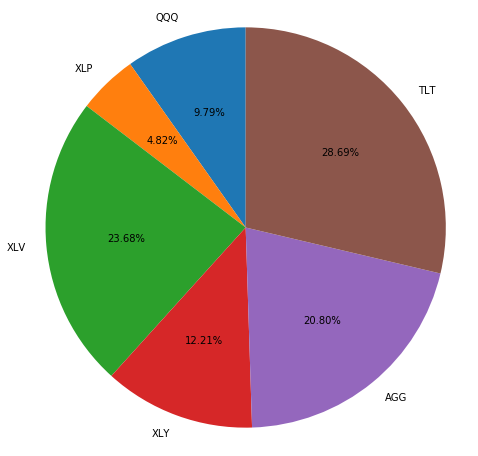

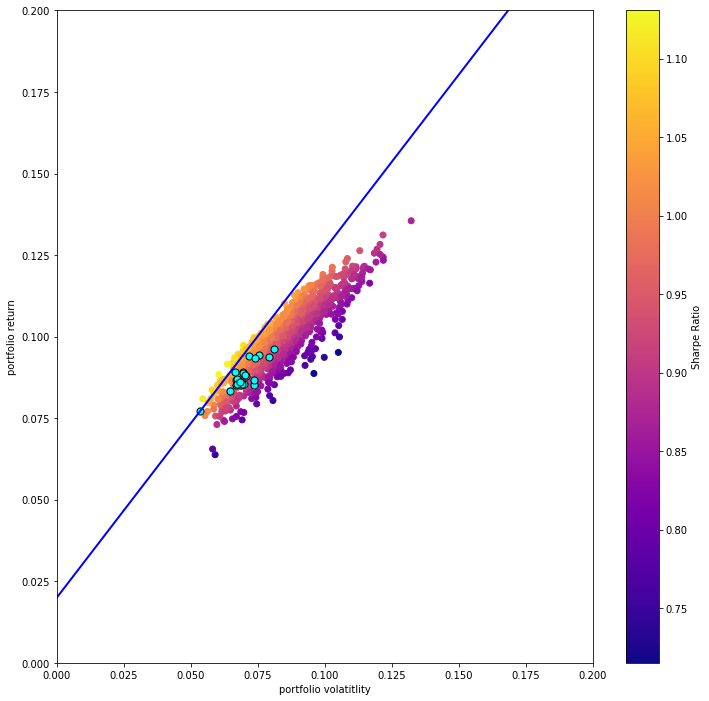

,QQQ,XLP,XLV,XLY,AGG,TLT,init_mean%,init_sigma%,init_sharpe,init_beta,init_mdd,rebal_mean%,rebal_sigma%,rebal_sharpe,rebal_beta,rebal_mdd,log_mean%,log_sigma%,log_sharpe
0,0.097942,0.048228,0.236766,0.122149,0.208011,0.286904,0.056548,0.082437,0.685973,0.371916,-0.073461,0.052361,0.069527,0.75324,0.273719,-0.068977,0.067801,0.069759,0.973638


In [37]:
test_top_2014, mean_test_top_2014 = ETF_split_10.test_compare(0.025, metric='sharpe', method='log')
mean_test_top_2014

# Markowitz Optimization

In [ ]:
train_end_2012 = '2012-12-31'
opt_weight_08, opt_sharpe_08, frontier_08 = ETF_rand.opt_frontier(startdate, train_end_2012, 0.04, 0.16, 0.025, 0.20) 

## Efficient Frontier by Optimization

In [51]:
# Objective function: portfolio volatility given fixed level of return
def get_sigma(weight):
    return ETFopt.meanvar_sharpe(weight)[1]

# Input Vector: annualized return from 0.025 to 0.200
return_vect = np.linspace(0.04,0.16,100)

# Record the minimal volatility for each 
frontier_vol = []

start_front = time()

# initial guess as equal weight
init_guess = eqweight

for return_value in return_vect:
    # Set up two constraints for opt: weight unity & fixed return
    constr = ({'type':'eq','fun':check_unity},
              {'type':'eq','fun':lambda w: ETFopt.meanvar_sharpe(w)[0] - return_value})
    
    # Store the result of minimising volatility
    min_vol_result = minimize(get_sigma, init_guess,method='SLSQP',bounds=bounds,constraints=constr)
    frontier_vol.append(min_vol_result['fun'])

end_front = time()
print('Time elapsed for Efficient Frontier:%1.4f'%(end_front - start_front))


Time elapsed for Efficient Frontier:29.5554


D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


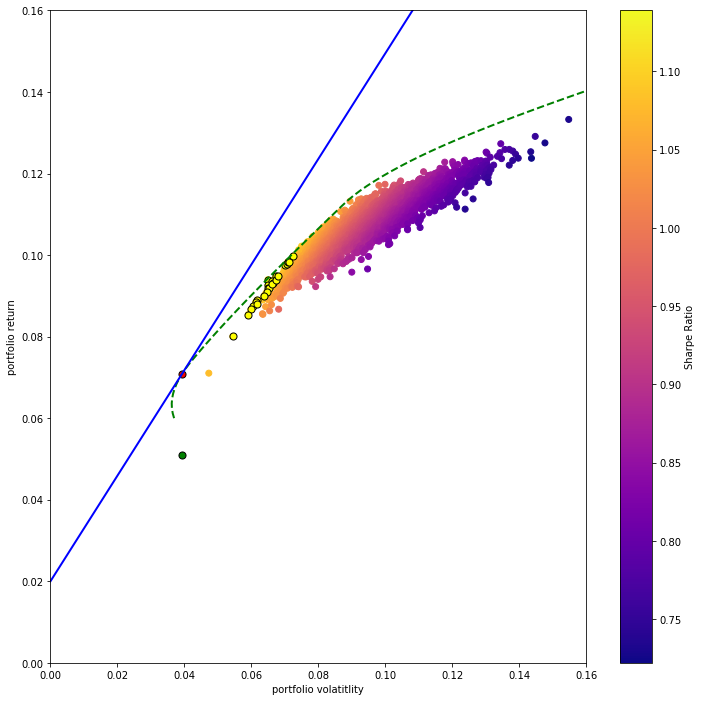

In [53]:
# Scatter plot of all (sigma, return)-tuple of the 2500 portfolios 
plt.figure(figsize=(12,12))
fig = plt.scatter(sharpe_sim['sigma%'], 
                  sharpe_sim['mean%'] + rf, 
                  c=sharpe_sim['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add yellow dots for top 25 Sharpe ratio
top1 = plt.scatter(sharpe_sim.head(rand_size//100)['sigma%'], 
                   sharpe_sim.head(rand_size//100)['mean%'] + rf, 
                   c='yellow', s=50, edgecolors='black')

# Add frontier line 
plt.plot(frontier_vol,return_vect + rf,'g--',linewidth=2)
plt.scatter(ETFopt.meanvar_sharpe(opt_weight)[1],ETFopt.meanvar_sharpe(opt_weight)[0],c='green',s=50,edgecolors='black')

# Add red dot for the Markowitz portfolio
top3 = plt.scatter(opt_sigma, opt_mean + rf, c='red', s=50, edgecolors='black')

# Add straight line of optimal portfolios
xline = np.linspace(0, 0.2, 500)
yline = opt_sharpe * xline + rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 20%
plt.ylim(ymin=0)
plt.ylim(ymax=0.16)

# Set sigma range from 0 to 24%
plt.xlim(xmin=0)
plt.xlim(xmax=0.16)
plt.show()